In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import dask as da
import xarray as xy
import matplotlib.pyplot as plt
from matplotlib import cm  #colormap                                                                                                                  
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from time import time
import os.path
import cftime
from copy import deepcopy

from scipy.stats import ks_2samp as ksTest

from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list("", ["white","purple","purple"],N=10)


In [2]:
def getCal(fileName):
    temp = xy.open_dataset(fileName,decode_times=False)
    return temp.time.calendar

def addSeasonArray(y):
    return xy.DataArray([GroupbySeason(y,x) for x in np.arange(len(y.time))],name='season',dims=['time'])

def GroupbySeason(df, ind):
    month = int(str(df['time'].isel(time=ind).coords).split('-')[1])
    if month in [12,1,2]:
        return 'DJF'
    elif month in [3,4,5]:
        return 'MAM'
    elif month in [6,7,8]:
        return 'JJA'
    elif month in [9,10,11]:
        return 'SON'

def startslice(startYear,fileName):
    sm = 1
    if getCal(fileName) == '360_day':
        startslice = cftime.Datetime360Day(startYear, sm, 1,0,0,0,0,-1,1)
    else:
        startslice = str(startYear)+str(sm).zfill(2)+'01'

    return startslice

def endslice(endYear,fileName):
    if getCal(fileName) == '360_day':
        endslice = cftime.Datetime360Day(endYear, 12, 30,23,0,0,0,-1,360)
    else:
        endslice = str(endYear)+'1231'

    return endslice


In [3]:
def wetDayPercentile(y,q=85):
    #note hard-coded wet-day threshold of >0.1mm/d                                                                                                    
    return y.where(y>0.1).reduce(np.nanpercentile,dim='time',q=q)


In [280]:
 # arguments should be passed in:                                                                                                                  
#"label": plot title: "[analysis scenario rcm gcm location]"                                                                                      
label = "ksTestTail test[scenario rcm gcm location]"
#"obs": input file with observational data (single timeseries, one variable, one point)                                                           
obs = 'dataFiles/prec.obs.nc'
#"cur": same as obs, but for historical period of simulation                                                                                      
cur = 'dataFiles/prec.cur.nc'
#"fut": same as "cur", but for future period of simulation                                                                                        
fut = 'dataFiles/prec.fut.nc'
#"png": name of 'png' file to write the figure                                                                                                    
png = "testKStestTail.png"
#"var": name of data variable in input files                                                                                                      
var = "prec"
#"txt": name of file to write tab-delimited numerical metric results                                                                              
txt = "testKStestTail.csv"


In [14]:
def callKStest(col):
    try:
        toReturn = ksTest(pHistDF[col].dropna().squeeze().values,obsDF[col].dropna().squeeze().values)
        return (toReturn.statistic, toReturn.pvalue)
    except:
        return (np.NaN, np.NaN)

def toDF(data):
    dataWhere = data.loc[data['time.season']==season]
    dataWhere = dataWhere.where(dataWhere>pThreshOne.sel(season=season))
    dataStacked = dataWhere.stack(allpoints=['lat','lon']).squeeze()                                                                             
    return dataStacked.to_pandas()                                                                                         

obsData = xy.open_dataset(obs)
pThreshOne = obsData[var].groupby('time.season').apply(wetDayPercentile,q=85)

pHist = xy.open_dataset(cur)
pFuture = xy.open_dataset(fut)


In [10]:
if getCal(cur) == '360_day':
    grouperString = 'season'
    pHist.coords['season'] = addSeasonArray(pHist)
    pFuture.coords['season'] = addSeasonArray(pFuture)
else:
    grouperString = 'time.season'


In [26]:
t1 = time()
ksAll = pd.DataFrame()
for season in ['DJF','JJA']:
    pHistDF = toDF(pHist[var])
    pFutureDF = toDF(pFuture[var])
    obsDF = toDF(obsData[var])

    ksOut = pd.DataFrame((callKStest(col) for col in pHistDF),index=pHistDF.columns)
    ksAll[(season,'statistic')] = ksOut[0]
    ksAll[(season,'pvalue')] = ksOut[1]

ksAll = ksAll.transpose()
ksAll.index = pd.MultiIndex.from_tuples(ksAll.index)
ksAll.sort_index()
ksAll = ksAll.transpose()
t2=time()
print ('calculation took '+str(np.round(t2-t1,2))+'s')


calculation took 1.18s


/home/ngoldenson/miniconda2/envs/forPy3/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


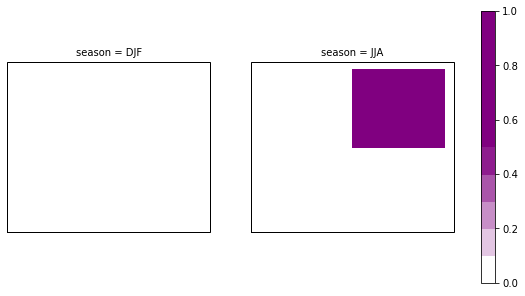

In [37]:
# for just a point or four, a map doesn't make much sense. 
# what would be a good accompanying visualization instead?
pValToPlot = ksAll.transpose().swaplevel(0,1).transpose()['pvalue'].to_xarray().to_array('season')
plotted = pValToPlot.plot.pcolormesh(transform=ccrs.PlateCarree(),col='season',col_wrap=2,
                                  subplot_kws={'projection':ccrs.LambertCylindrical(200)},
                                         figsize=[10,5],vmin=0,vmax=1,cmap=mycmap)
seasons = ['DJF','JJA']
for i, ax in enumerate(plotted.axes.flat):
    ax.coastlines(linewidth=1.4)

In [35]:
# write out the text file with the results
ksAll.to_csv(txt)

In [104]:
# demo, read it back in:
ksAllAgain = pd.read_csv(txt,index_col=[0,1],header=[0,1])
ksAllAgain

DJF                 JJA          
                  statistic    pvalue statistic    pvalue
lat       lon                                            
-33.08393 299.250  0.415158  0.000002  0.323544  0.000129
          300.375  0.346154  0.000021  0.234514  0.006874
-31.96244 299.250  0.248370  0.010386  0.256437  0.003600
          300.375  0.268485  0.000334  0.100394  0.589222

### instead, let's select just one lat/lon point first

In [ ]:
# can't combine these all in one dataframe with different time indices

In [310]:
# version for only one point, not set of lats/lons:
def toDF(data):
    dataWhere = data.sel(time=data['time.season']==season)
    dataWhere = dataWhere.where(dataWhere>pThreshOne.sel(season=season))
    return dataWhere.to_pandas()    

#columns are seasons instead of lats/lons
def callKStest(col):
    try:
        toReturn = ksTest(histDF[col].dropna().squeeze().values,obsDF[col].dropna().squeeze().values)
        return (toReturn.statistic, toReturn.pvalue)
    except:
        return (np.NaN, np.NaN)


In [311]:
obsData = xy.open_dataset(obs)
pThreshOne = obsData[var].groupby('time.season').apply(wetDayPercentile,q=85)

pHist = xy.open_dataset(cur)
pFuture = xy.open_dataset(fut)

pThreshOne = pThreshOne.isel(lat=0,lon=0)

In [313]:
t1 = time()
obsDF = pd.DataFrame()
histDF = pd.DataFrame()
futureDF = pd.DataFrame()
ksAll = pd.DataFrame()
for season in ['DJF','MAM','JJA','SON']:
    obsDF[season] = toDF(obsData[var].isel(lat=0,lon=0))
    histDF[season] = toDF(pHist[var].isel(lat=0,lon=0))
    futureDF[season] = toDF(pFuture[var].isel(lat=0,lon=0))
    
ksOut = pd.DataFrame((callKStest(col) for col in histDF),index=histDF.columns)
ksOut.columns = ['statistic','pValue']

t2=time()
print ('calculation took '+str(np.round(t2-t1,2))+'s')

calculation took 1.52s


In [314]:
ksOut.to_csv(txt)

In [315]:
#test read back in:
ksOutAndBack = pd.read_csv(txt,index_col=0)
ksOutAndBack

,statistic,pValue
DJF,0.135546,0.096165
MAM,NaN,NaN
JJA,NaN,NaN
SON,NaN,NaN


In [ ]:
binsToUse = np.logspace(0,2,100)
plt.figure(figsize=[15,8])
for i, season in enumerate(['DJF','MAM','JJA','SON']):
    ax = plt.subplot(2,2,i+1)
    obsDF[season].plot.hist(ax=ax,bins=binsToUse,stacked=False,alpha=0.5) 
    histDF[season].plot.hist(ax=ax,bins=binsToUse,stacked=False,alpha=0.5) 
    futureDF[season].plot.hist(ax=ax,bins=binsToUse,stacked=False,alpha=0.5) 
    ax.plot(np.zeros(10)+pThreshDF[season],np.logspace(0,1,10),linestyle='--',color='b',label='85th percentile obs')    

    ax.set(xscale='log')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
    if i>1:
        try:
            units = obsData[var].attrs['units']
            plt.xlabel(units)
        except:
            plt.xlabel('default units in file')
    plt.title(season)
    plt.legend(loc='upper left')
    ax.annotate('statistic: '+str(np.round(ksOut.T[season]['statistic'],2)),xy=(0.7,0.9),
                xycoords='axes fraction')
    ax.annotate('p value:  '+str(np.round(ksOut.T[season]['pValue'],2)),xy=(0.7,0.85),
                xycoords='axes fraction')

plt.suptitle(label)
plt.savefig(png)

### This is not the ideal test dataset. Let's choose another:

In [287]:
#"label": plot title: "[analysis scenario rcm gcm location]"                                                                                      
label = "ksTestTail test[scenario rcm gcm location]"
#"obs": input file with observational data (single timeseries, one variable, one point)                                                           
obs = 'dataFiles/prec.maurer.observed.daily.common.nc'
#"cur": same as obs, but for historical period of simulation                                                                                      
cur = 'dataFiles/prec.ECP2.gfdl-current.daily.common.nc'
#"fut": same as "cur", but for future period of simulation                                                                                        
fut = 'dataFiles/prec.ECP2.gfdl-future.daily.common.nc'
#"png": name of 'png' file to write the figure                                                                                                    
png = "testKStestTail.png"
#"var": name of data variable in input files                                                                                                      
var = "prec"
#"txt": name of file to write tab-delimited numerical metric results                                                                              
txt = "testKStestTail.csv"


In [288]:
obsData = xy.open_dataset(obs)
pThreshOne = obsData[var].groupby('time.season').apply(wetDayPercentile,q=85)

pHist = xy.open_dataset(cur)
pFuture = xy.open_dataset(fut)


In [289]:
pThreshOne = pThreshOne.isel(lat=1,lon=1)

In [290]:
t1 = time()
dfBySeason = pd.DataFrame()
ksAll = pd.DataFrame()
for season in ['DJF','MAM','JJA','SON']:
    dfBySeason[('observations',season)] = toDF(obsData[var].isel(lat=1,lon=1))
    dfBySeason[('historical',season)] = toDF(pHist[var].isel(lat=1,lon=1))
    dfBySeason[('future',season)] = toDF(pFuture[var].isel(lat=1,lon=1))
    
dfBySeason = dfBySeason.transpose()
dfBySeason.index = pd.MultiIndex.from_tuples(dfBySeason.index)
dfBySeason = dfBySeason.transpose()

ksOut = pd.DataFrame((callKStest(col) for col in dfBySeason['historical']),index=dfBySeason['historical'].columns)
ksOut.columns = ['statistic','pValue']

t2=time()
print ('calculation took '+str(np.round(t2-t1,2))+'s')

calculation took 2.39s


/home/ngoldenson/miniconda2/envs/forPy3/lib/python3.6/site-packages/scipy/stats/stats.py:4861: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / n1
/home/ngoldenson/miniconda2/envs/forPy3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/ngoldenson/miniconda2/envs/forPy3/lib/python3.6/site-packages/scipy/stats/stats.py:4867: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


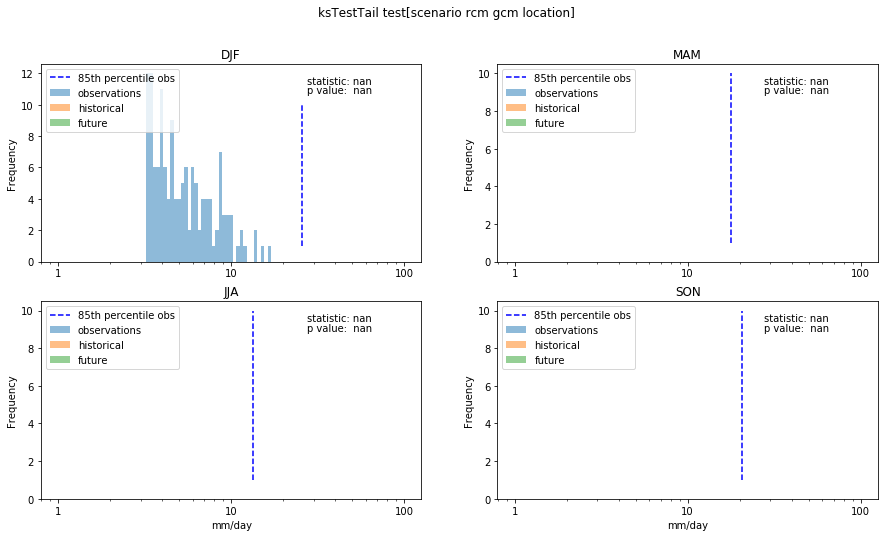

In [291]:
binsToUse = np.logspace(0,2,100)
toPlotHists = dfBySeason.T.swaplevel(0,1).T
plt.figure(figsize=[15,8])
for i, season in enumerate(['DJF','MAM','JJA','SON']):
    ax = plt.subplot(2,2,i+1)
    toPlotHists[season].plot.hist(ax=ax,bins=binsToUse,stacked=False,alpha=0.5) 
    ax.plot(np.zeros(10)+pThreshDF[season],np.logspace(0,1,10),linestyle='--',color='b',label='85th percentile obs')    

    ax.set(xscale='log')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
    if i>1:
        try:
            units = obsData[var].attrs['units']
            plt.xlabel(units)
        except:
            plt.xlabel('default units in file')
    plt.title(season)
    plt.legend(loc='upper left')
    ax.annotate('statistic: '+str(np.round(ksOut.T[season]['statistic'],2)),xy=(0.7,0.9),
                xycoords='axes fraction')
    ax.annotate('p value:  '+str(np.round(ksOut.T[season]['pValue'],2)),xy=(0.7,0.85),
                xycoords='axes fraction')

plt.suptitle(label)
plt.savefig(png)

In [292]:
ksOut

,statistic,pValue
DJF,NaN,NaN
MAM,NaN,NaN
JJA,NaN,NaN
SON,NaN,NaN


In [251]:
obsData[var].isel(lat=1,lon=1).time

<xarray.DataArray 'time' (time: 10958)>
array(['1970-12-01T12:00:00.000000000', '1970-12-02T12:00:00.000000000',
       '1970-12-03T12:00:00.000000000', ..., '2000-11-28T12:00:00.000000000',
       '2000-11-29T12:00:00.000000000', '2000-11-30T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1970-12-01T12:00:00 ... 2000-11-30T12:00:00
    lat      float32 40.25
    lon      float32 254.75
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time